# Analysis of empty partitions

**Author**: Sandro Campos

This notebook aims to achieve a deeper understanding of the empty partitions a catalog may contain after filtering of some kind.

In [1]:
import lsdb
import healpy as hp
import numpy as np

/jet/home/scampos/.conda/envs/lsdb/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Initialize a Dask Client

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)
client

/jet/home/scampos/.conda/envs/lsdb/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/jet/home/scampos/.conda/envs/lsdb/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/jet/home/scampos/.conda/envs/lsdb/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/jet/home/scampos/.conda/envs/lsdb/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 64,Total memory: 125.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33845,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 125.00 GiB
Comm: tcp://127.0.0.1:38655,Total threads: 16
Dashboard: http://127.0.0.1:37349/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:44533,


### Utility methods

In [3]:
from hipscat.inspection import plot_pixels

def construct_density_map(pixel_map, partition_sizes):
    # Compute density for each pixel, at each order
    density_map = {}
    for pixel, partition_idx in pixel_map.items():
        pixel_area = hp.nside2pixarea(hp.order2nside(pixel.order))
        density_map[pixel] = partition_sizes[partition_idx] / pixel_area
    return density_map
    
def explode_pixel_map(density_map, max_order, binary):
    # Explode density map to maximum order
    exploded_density_map = np.full(hp.order2npix(max_order),  hp.pixelfunc.UNSEEN)
    for pixel, density in density_map.items():
        explosion_factor = 4 ** (max_order - pixel.order)
        exploded_pixels = [
            *range(
                pixel.pixel * explosion_factor,
                (pixel.pixel + 1) * explosion_factor,
            )
        ]
        if binary:
            # Pixel value is 1 if it has points, 2 if does not
            exploded_density_map[exploded_pixels] = 1 if density > 0 else 2
        else:
            # Pixel values correspond to density
            exploded_density_map[exploded_pixels] = density
    return exploded_density_map

def plot_density_map(pixel_map, partition_sizes):  
    density_map = construct_density_map(pixel_map, partition_sizes)
    pixels = list(pixel_map.keys())
    max_order = np.max(pixels).order
    exploded_density_map = explode_pixel_map(density_map, max_order, binary=False)
    hp.mollview(exploded_density_map, nest=True, title="Pixel density map")
    
def plot_non_empty_pixel_map(pixel_map, partition_sizes):
    density_map = construct_density_map(pixel_map, partition_sizes)
    pixels = list(pixel_map.keys())
    max_order = np.max(pixels).order
    exploded_density_map = explode_pixel_map(density_map, max_order, binary=True)
    hp.mollview(exploded_density_map, nest=True, title="Pixel non-empty map", unit="1 if has data, 2 if not")

### Load ZTF and Gaia

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
12490637312,108000449961107213,44.996152,0.005626,18.113300,17.627800,17.406500,364,381,18,18.143208,17.569102,17.373423,3,0,0
98125742080,108020450140974134,45.014110,0.019775,21.565901,21.134199,21.414301,42,114,1,21.298568,21.007693,20.599543,3,0,0
104371060736,108010450069569645,45.007042,0.015954,22.047899,21.641199,21.655001,5,17,0,21.552179,21.405765,NaN,3,0,0
116614234112,108020450049144323,45.004993,0.019910,14.892500,14.105700,13.792100,371,387,18,14.916993,14.028394,13.727368,3,0,0
118560391168,108020450042525676,45.004327,0.021077,19.278601,18.040701,16.853201,126,302,15,19.344950,17.897595,16.653296,3,0,0


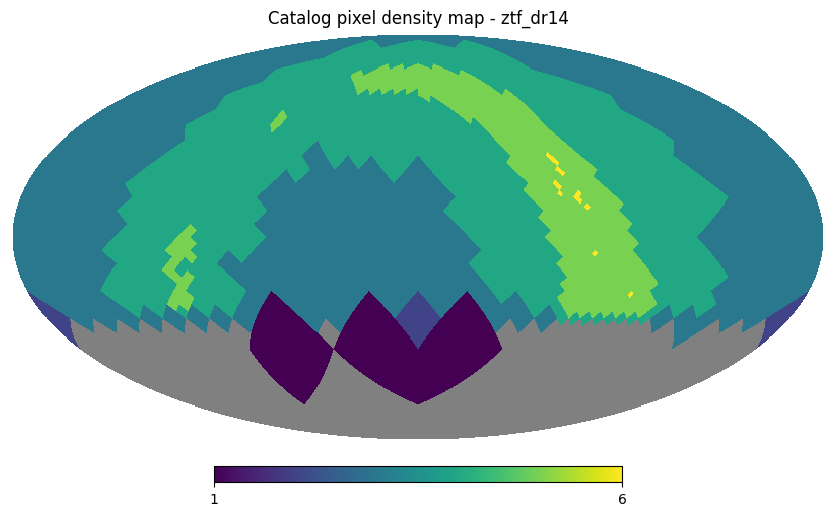

In [4]:
ztf_dr14 = lsdb.read_hipscat("tmp_ondemand_ocean_phy210048p_symlink/shared/hipscat/catalogs/ztf_axs/ztf_dr14")
plot_pixels(ztf_dr14.hc_structure)
ztf_dr14.head(n=5)

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Npix,Dir
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1129576398848,1636148068921376768,Gaia DR3 24019832236429184,24019832236429184,441233822,2016.0,33.851085,0.766448,9.652315,0.761931,1.144887,...,NaN,NaN,NaN,NaN,NaN,NaN,None,2,0,0
1700807049216,1636148068921376768,Gaia DR3 24769042036870656,24769042036870656,620766243,2016.0,36.483007,0.267959,11.946436,0.275082,0.880251,...,NaN,NaN,NaN,NaN,NaN,NaN,None,2,0,0
1872605741056,1636148068921376768,Gaia DR3 31224931933835776,31224931933835776,615811159,2016.0,48.743104,0.069652,16.127102,0.059458,0.102395,...,0.0072,0.0018,0.0188,0.0039,0.001,0.0103,MARCS,2,0,0
1971389988864,1636148068921376768,Gaia DR3 72058285527662592,72058285527662592,546860473,2016.0,33.816981,5.161226,9.651732,8.501252,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,2,0,0
2220498092032,1636148068921376768,Gaia DR3 72807499622776832,72807499622776832,754153380,2016.0,36.495653,0.711940,11.966690,0.736417,1.427530,...,NaN,NaN,NaN,NaN,NaN,NaN,None,2,0,0


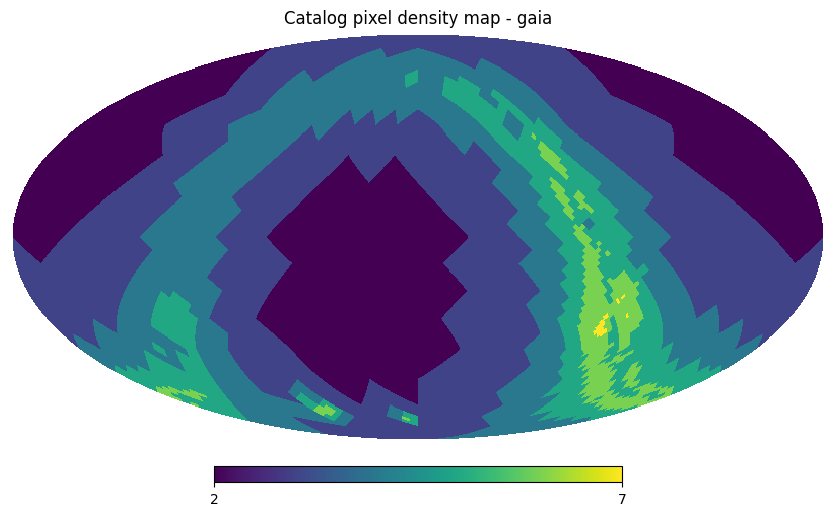

In [5]:
gaia_dr3 = lsdb.read_hipscat("tmp_ondemand_ocean_phy210048p_symlink/shared/hipscat/catalogs/gaia_dr3")
plot_pixels(gaia_dr3.hc_structure)
gaia_dr3.head()

Gaia is an all-sky coverage survey, unlike ZTF. 

## Premise

A user often expects to have a catalog after filtering containing __non-empty partitions__ with points for the selected filter. This is not always the case because for the cone, polygonal and box searches we make HEALpy return all the pixels that __overlap__ with the filter, not only those whose centers lie in it. This is necessary to prevent information loss!

For more information refer to [`query_disc`](https://healpy.readthedocs.io/en/latest/generated/healpy.query_disc.html), [`query_polygon`](https://healpy.readthedocs.io/en/latest/generated/healpy.query_polygon.html) and [`query_strip`](https://healpy.readthedocs.io/en/latest/generated/healpy.query_strip.html), in particular to the `inclusive` argument.

## Filtering by RA

### In ZTF

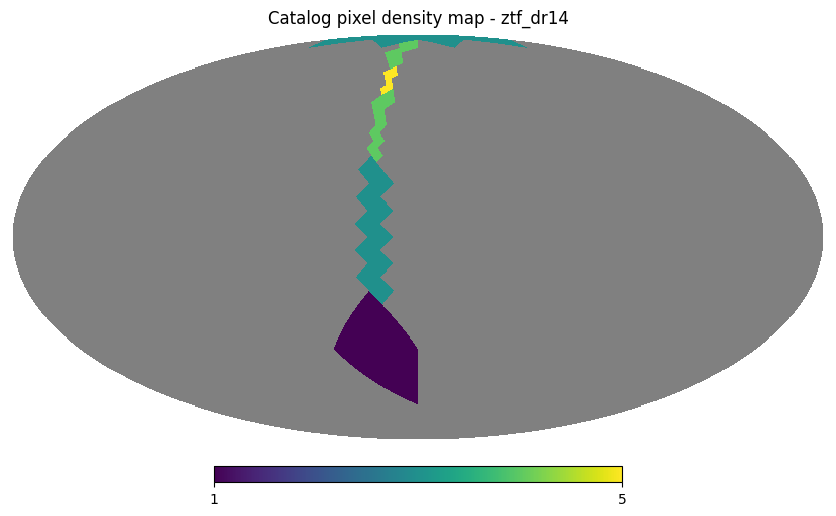

In [6]:
ztf_search_catalog = ztf_dr14.box(ra=(20, 21))
plot_pixels(ztf_search_catalog.hc_structure)

In [7]:
print(f"{ztf_search_catalog._ddf.npartitions} partitions")

41 partitions


In [8]:
%%time

ztf_partition_sizes = ztf_search_catalog._ddf.map_partitions(len).compute()
ztf_partition_sizes

CPU times: user 4.34 s, sys: 1.42 s, total: 5.76 s
Wall time: 3min 16s


0      99084
1      62528
2      29191
3      76410
4      36365
5      78642
6     101283
7      92430
8      22592
9       2041
10    118157
11     68227
12     13147
13      9538
14     75034
15     93012
16     68115
17     36529
18         0
19         0
20     46699
21     69403
22     93615
23     60143
24     19181
25      8392
26     14452
27      8075
28         0
29         0
30         0
31     41952
32     86809
33     54081
34     89437
35     49340
36     97883
37     48462
38     92669
39     51174
40     71590
dtype: int64

In [9]:
ztf_empty_partitions = ztf_partition_sizes[ztf_partition_sizes==0]
print(f"{len(ztf_empty_partitions)} empty partitions")

5 empty partitions


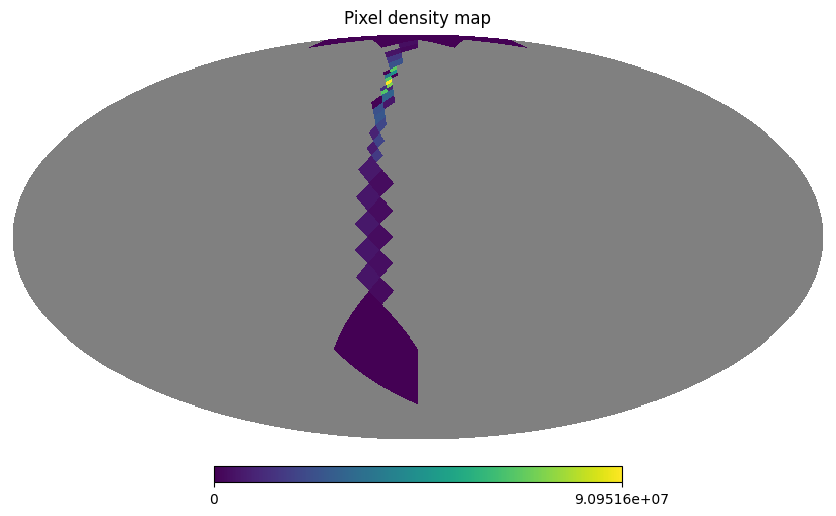

In [10]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

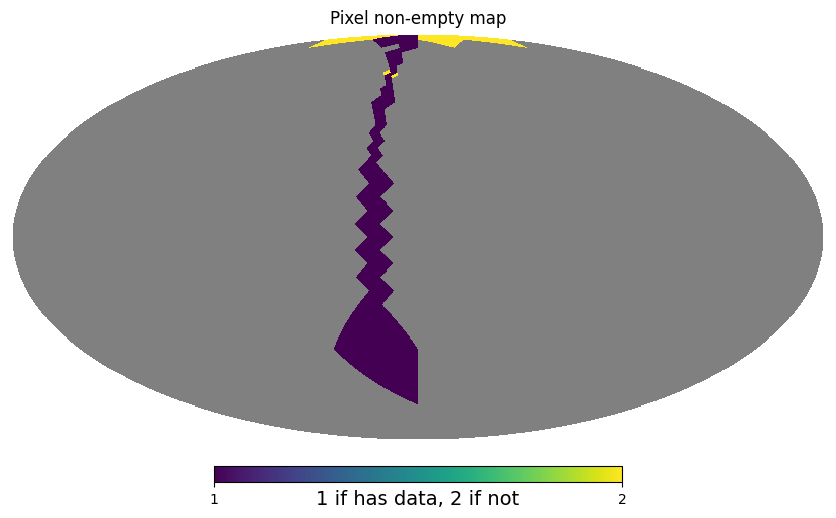

In [11]:
plot_non_empty_pixel_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

### In Gaia

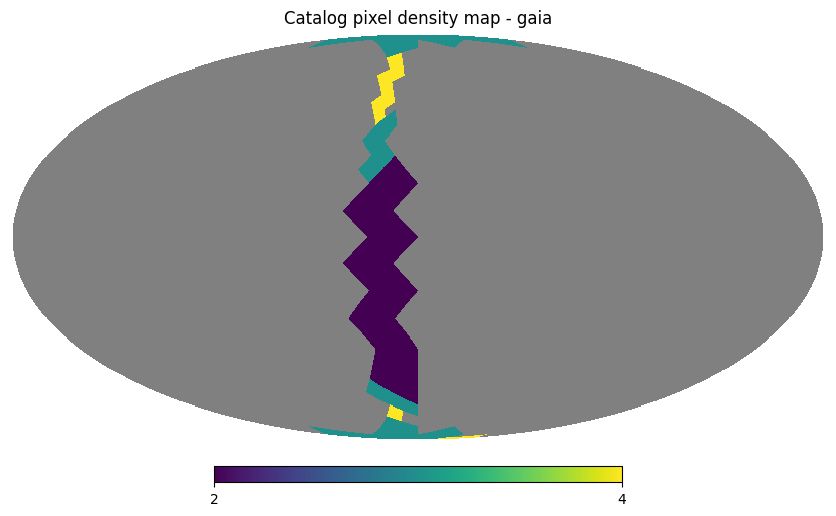

In [12]:
gaia_search_catalog = gaia_dr3.box(ra=(20, 21))
plot_pixels(gaia_search_catalog.hc_structure)

In [13]:
print(f"{gaia_search_catalog._ddf.npartitions} partitions")

38 partitions


In [14]:
%%time

gaia_partition_sizes = gaia_search_catalog._ddf.map_partitions(len).compute()
gaia_partition_sizes

CPU times: user 4.51 s, sys: 1.34 s, total: 5.85 s
Wall time: 2min 58s


0      27680
1      18898
2      49195
3      32841
4      47964
5      50179
6      13417
7       1262
8      81796
9     124691
10    117664
11     24848
12         0
13     85578
14     72364
15     41749
16     27656
17      5657
18         0
19         0
20         0
21      9855
22     44958
23      9471
24     49432
25     13043
26      5786
27     18269
28     48066
29     16492
30      6915
31     10723
32     38094
33      9270
34     45829
35         0
36         0
37         0
dtype: int64

In [15]:
gaia_empty_partitions = gaia_partition_sizes[gaia_partition_sizes==0]
print(f"{len(gaia_empty_partitions)} empty partitions")

7 empty partitions


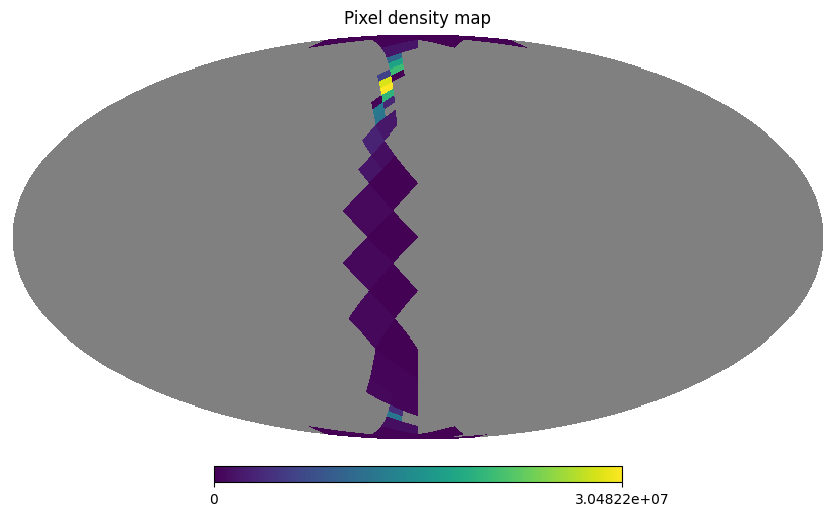

In [16]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)

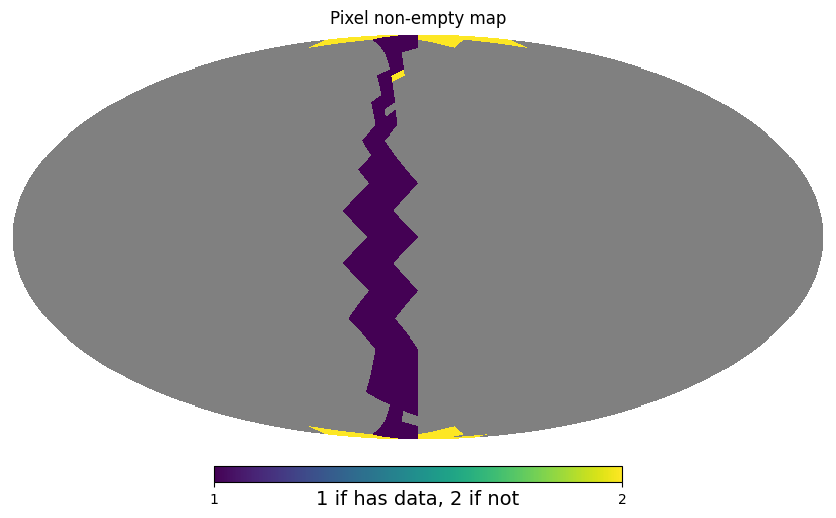

In [17]:
plot_non_empty_pixel_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)

## Filtering by DEC

### In ZTF

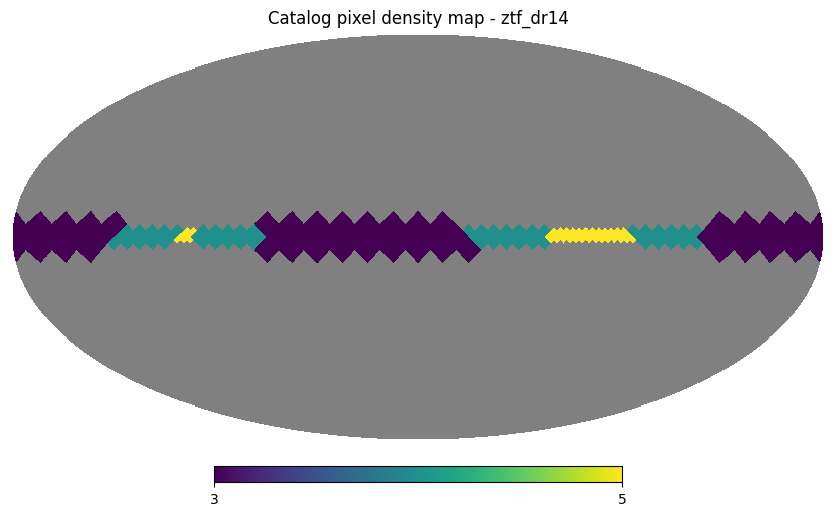

In [18]:
ztf_search_catalog = ztf_dr14.box(dec=(0, 2))
plot_pixels(ztf_search_catalog.hc_structure)

In [19]:
print(f"{ztf_search_catalog._ddf.npartitions} partitions")

179 partitions


In [20]:
ztf_partition_sizes = ztf_search_catalog._ddf.map_partitions(len).compute()
ztf_partition_sizes

0       68046
1       91055
2       86890
3      169994
4           0
        ...  
174     83535
175         0
176         0
177         0
178         0
Length: 179, dtype: int64

In [21]:
empty_partitions = ztf_partition_sizes[ztf_partition_sizes==0]
print(f"There are {len(empty_partitions)} empty partitions")

There are 55 empty partitions


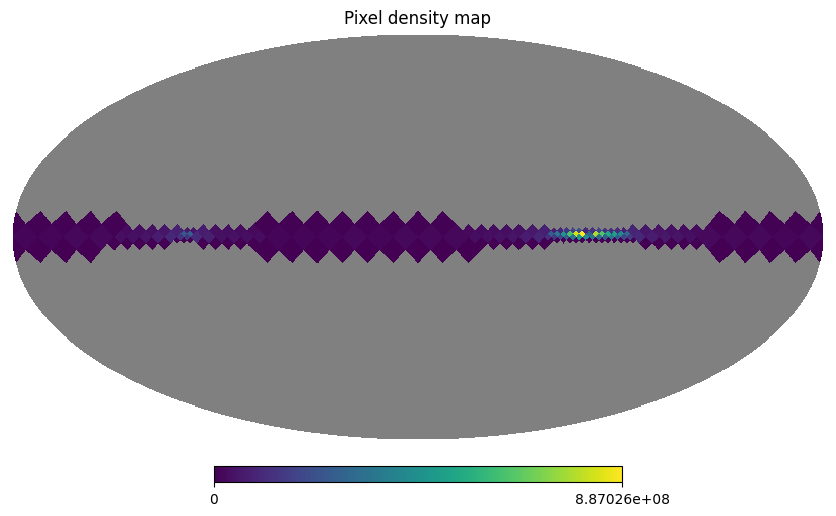

In [22]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

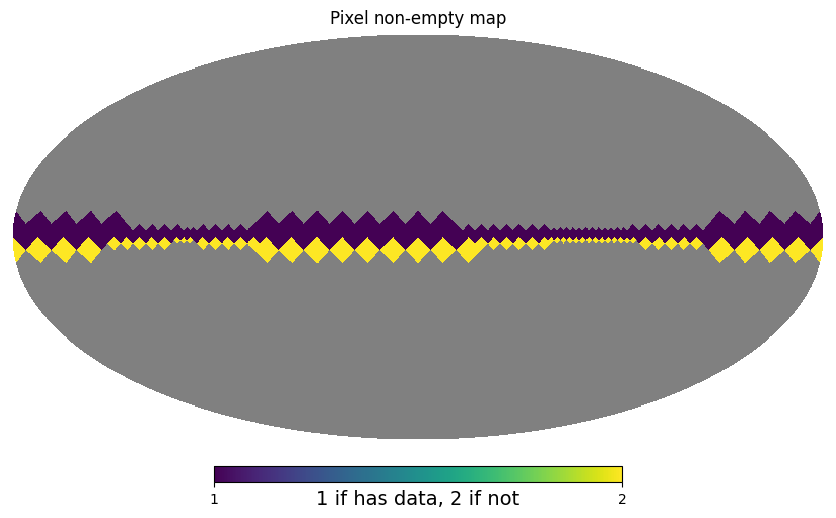

In [23]:
plot_non_empty_pixel_map(ztf_search_catalog._ddf_pixel_map, ztf_partition_sizes)

### In Gaia

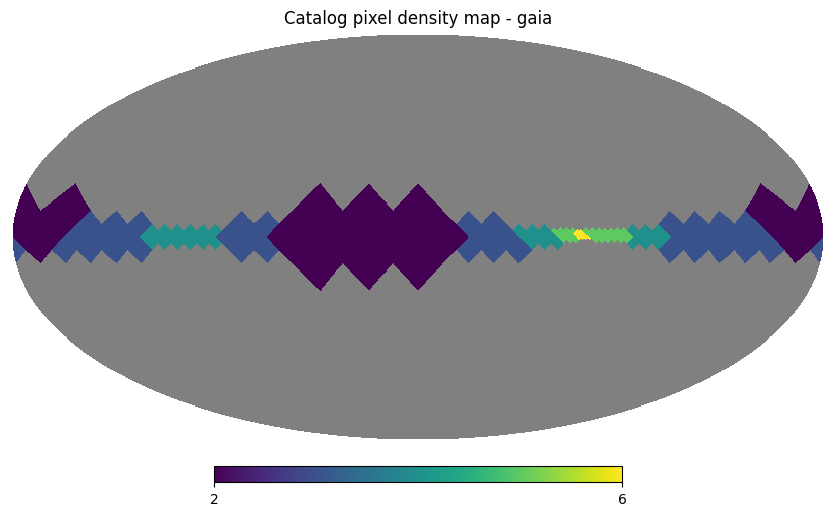

In [24]:
gaia_search_catalog = gaia_dr3.box(dec=(0, 2))
plot_pixels(gaia_search_catalog.hc_structure)

In [25]:
print(f"{gaia_search_catalog._ddf.npartitions} partitions")

149 partitions


In [26]:
gaia_partition_sizes = gaia_search_catalog._ddf.map_partitions(len).compute()
gaia_partition_sizes

0      15036
1      32180
2      28214
3      79703
4          0
       ...  
144    64941
145        0
146        0
147        0
148        0
Length: 149, dtype: int64

In [27]:
empty_partitions = gaia_partition_sizes[gaia_partition_sizes==0]
print(f"There are {len(empty_partitions)} empty partitions")

There are 43 empty partitions


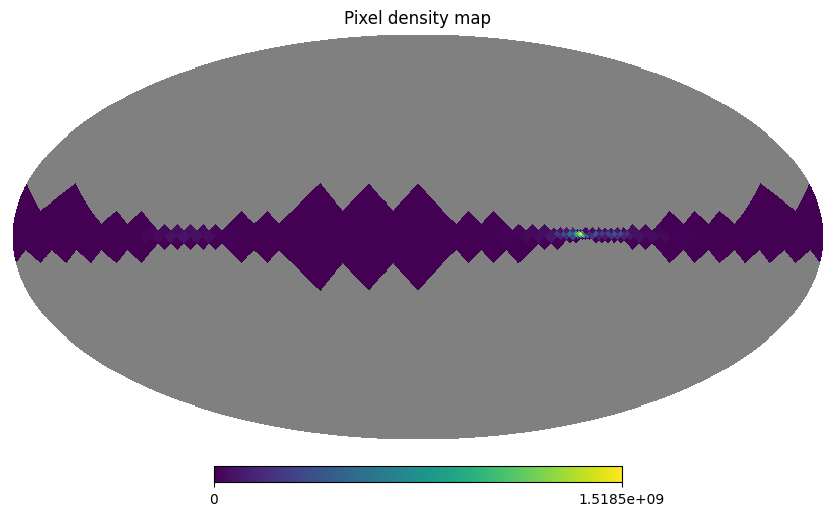

In [28]:
# Display a map of density of points per pixel (n_points / pixel_area)
plot_density_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)

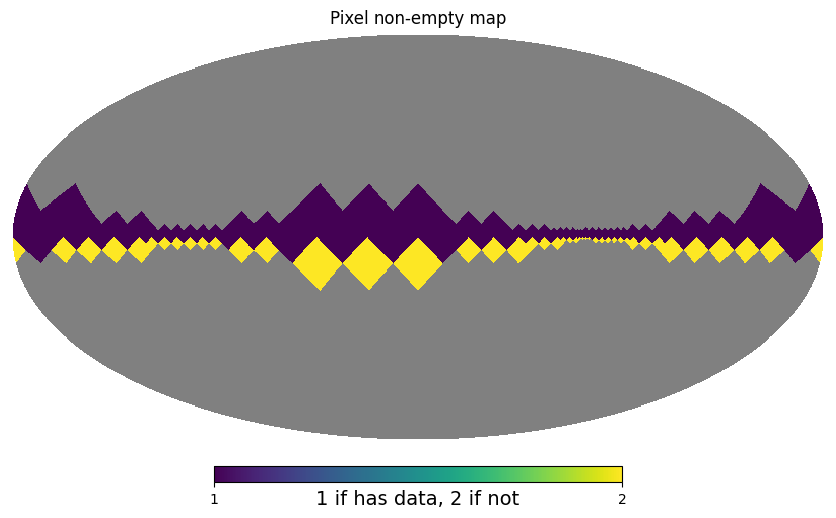

In [29]:
plot_non_empty_pixel_map(gaia_search_catalog._ddf_pixel_map, gaia_partition_sizes)

In [30]:
client.close()

2024-02-15 17:01:38,085 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-02-15 17:01:38,086 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-02-15 17:01:38,087 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-02-15 17:01:38,087 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
